# Part 6.6 - Analysis Topic Model of Specific Topics
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics, plot_heatmap, plot_avg, plot_hot
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-02-03 21:59:42


**In this part, we will:**
1. define hotest annual topics and plot first 20 of them by combined plots.
2. select several potential topics and plot them by point plots.

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


topic_  weight_  \
0       0  0.00657   
1       1  0.01074   
2       2  0.02215   
3       3  0.00384   
4       4  0.00901   

                                                                                                                 keywords_  
0  train railway leave trains station passengers return dep day tickets service stations express run railways fares spe...  
1  prices advertisements column suit latest ladies suits made street quality goods good wear style special styles fit c...  
2   time good year made great present work years fact number past season week large make place success doubt interest ago   
3  plaintiff defendant claim court costs judgment case witness evidence paid amount pay appeared gave made plaintiffs c...  
4  found death body deceased man inquest dead named evidence witness died suicide morning murder wife returned house ve...

**Docmument - dominant topics dataframe:**

In [4]:
path = r'../models/train/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (3025602, 6)


id       region  year  topic    weight  \
2913837  29678700   Wellington  1916     42  0.867361   
393770    5080833      unknown  1894     99  0.562639   
2357685  25364382  Marlborough  1913     20  0.385364   
1862989  18607941   Wellington  1917     50  0.237382   
1579198  16663020      Waikato  1920    112  0.212661   

                                                                keywords  
2913837  naval ships british navy fleet german sea vessels submarine ...  
393770   timaru christchurch akaroa lyttelton canterbury street bay r...  
2357685  auckland wellington left due london lyttelton october sydney...  
1862989  years wellington new_zealand death late auckland mrs ago son...  
1579198  advertisements office printing paper column cards published ...

**Average topic weight dataframe:**

In [6]:
path = r'../models/train/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (20800, 4)


year  topic    weight  \
13216  1908     16  0.005748   
865    1843     65  0.002828   
20258  1943     58  0.012046   
12440  1901     40  0.001118   
2644   1852     44  0.004238   

                                                              keywords  
13216  meat butter dairy milk cheese farmers factory new_zealand pr...  
865    court accused fined charged witness police defendant case ch...  
20258  american new_york united_states america president washington...  
12440  government provincial province council colony general superi...  
2644   hotel proprietor accommodation public spirits wines good tra...

## 2 General Distribution of Topics

**We plot all the annual average weight to see the general distribution:**

In [8]:
df_plt = df_avgweight[['year', 'topic', 'weight']]

df_plt = pd.pivot_table(data=df_plt,
                        index='topic',
                        values='weight',
                        columns='year')
scaler = MinMaxScaler()
df_plt_scaled = pd.DataFrame(scaler.fit_transform(df_plt),columns = df_plt.columns)
df_plt.head()

year       1839      1840      1841      1842      1843      1844      1845  \
topic                                                                         
0      0.000022  0.000081  0.000270  0.000472  0.000157  0.000616  0.000282   
1      0.000425  0.000503  0.000333  0.000590  0.000844  0.000305  0.000884   
2      0.000911  0.001999  0.004577  0.007803  0.006000  0.005266  0.012652   
3      0.000013  0.000763  0.000861  0.004253  0.002466  0.001138  0.006959   
4      0.000030  0.004680  0.001153  0.002530  0.003183  0.001683  0.003486   

year       1846      1847      1848      1849      1850      1851      1852  \
topic                                                                         
0      0.000230  0.000704  0.000440  0.000394  0.000306  0.000340  0.000685   
1      0.001308  0.000399  0.000223  0.000602  0.000258  0.000373  0.000296   
2      0.005027  0.005006  0.005479  0.006844  0.005857  0.007383  0.007212   
3      0.002579  0.001636  0.001218  0.002733  0.002590  0.002712  0.003814   
4      0.006039  0.005057  0.003675  0.002324  0.005989  0.004916  0.003042   

year       1853      1854      1855      1856      1857      1858      1859  \
topic                                                                         
0      0.000698  0.000197  0.000274  0.000244  0.000524  0.000451  0.000802   
1      0.000696  0.000368  0.000242  0.000234  0.000275  0.000262  0.000449   
2      0.009742  0.004862  0.008156  0.006929  0.010789  0.009751  0.010080   
3      0.002096  0.001259  0.000836  0.002024  0.003135  0.005846  0.004190   
4      0.005192  0.001692  0.002366  0.002706  0.004664  0.004596  0.003403   

year       1860      1861      1862      1863      1864      1865      1866  \
topic                                                                         
0      0.000467  0.000534  0.000764  0.000905  0.000799  0.000837  0.001010   
1      0.000828  0.000409  0.000438  0.000457  0.000512  0.000887  0.000888   
2      0.010110  0.009226  0.009443  0.010268  0.010517  0.009100  0.009065   
3      0.007184  0.004613  0.006127  0.005429  0.005269  0.006224  0.008407   
4      0.003165  0.004317  0.006112  0.006264  0.004596  0.006609  0.005184   

year       1867      1868      1869      1870      1871      1872      1873  \
topic                                                                         
0      0.002043  0.001154  0.001104  0.001740  0.001237  0.000863  0.001033   
1      0.001179  0.000729  0.000836  0.000823  0.001327  0.001013  0.000828   
2      0.009334  0.008351  0.009646  0.009341  0.007727  0.008748  0.008242   
3      0.007609  0.008323  0.007268  0.008017  0.006476  0.006784  0.005346   
4      0.004246  0.005223  0.005126  0.005617  0.006927  0.005225  0.005241   

year       1874      1875      1876      1877      1878      1879      1880  \
topic                                                                         
0      0.001512  0.001617  0.002872  0.004281  0.004100  0.003346  0.003508   
1      0.001298  0.001260  0.001327  0.001422  0.001341  0.001102  0.001619   
2      0.007895  0.008845  0.007838  0.007663  0.007088  0.007506  0.007536   
3      0.006355  0.006143  0.006924  0.006313  0.005549  0.005390  0.005856   
4      0.005408  0.007283  0.007697  0.006970  0.005759  0.007906  0.009214   

year       1881      1882      1883      1884      1885      1886      1887  \
topic                                                                         
0      0.003576  0.003660  0.002813  0.003203  0.003460  0.002923  0.003003   
1      0.001521  0.001247  0.001468  0.001667  0.001813  0.002013  0.002295   
2      0.007868  0.008459  0.008569  0.007830  0.008505  0.009338  0.008646   
3      0.005680  0.005091  0.005931  0.005574  0.004960  0.006112  0.005488   
4      0.008826  0.013847  0.012790  0.013565  0.010387  0.014249  0.012215   

year       1888      1889      1890      1891      1892      1893      1894  \
topic                                      

**Plot:** <a name="hot"></a>

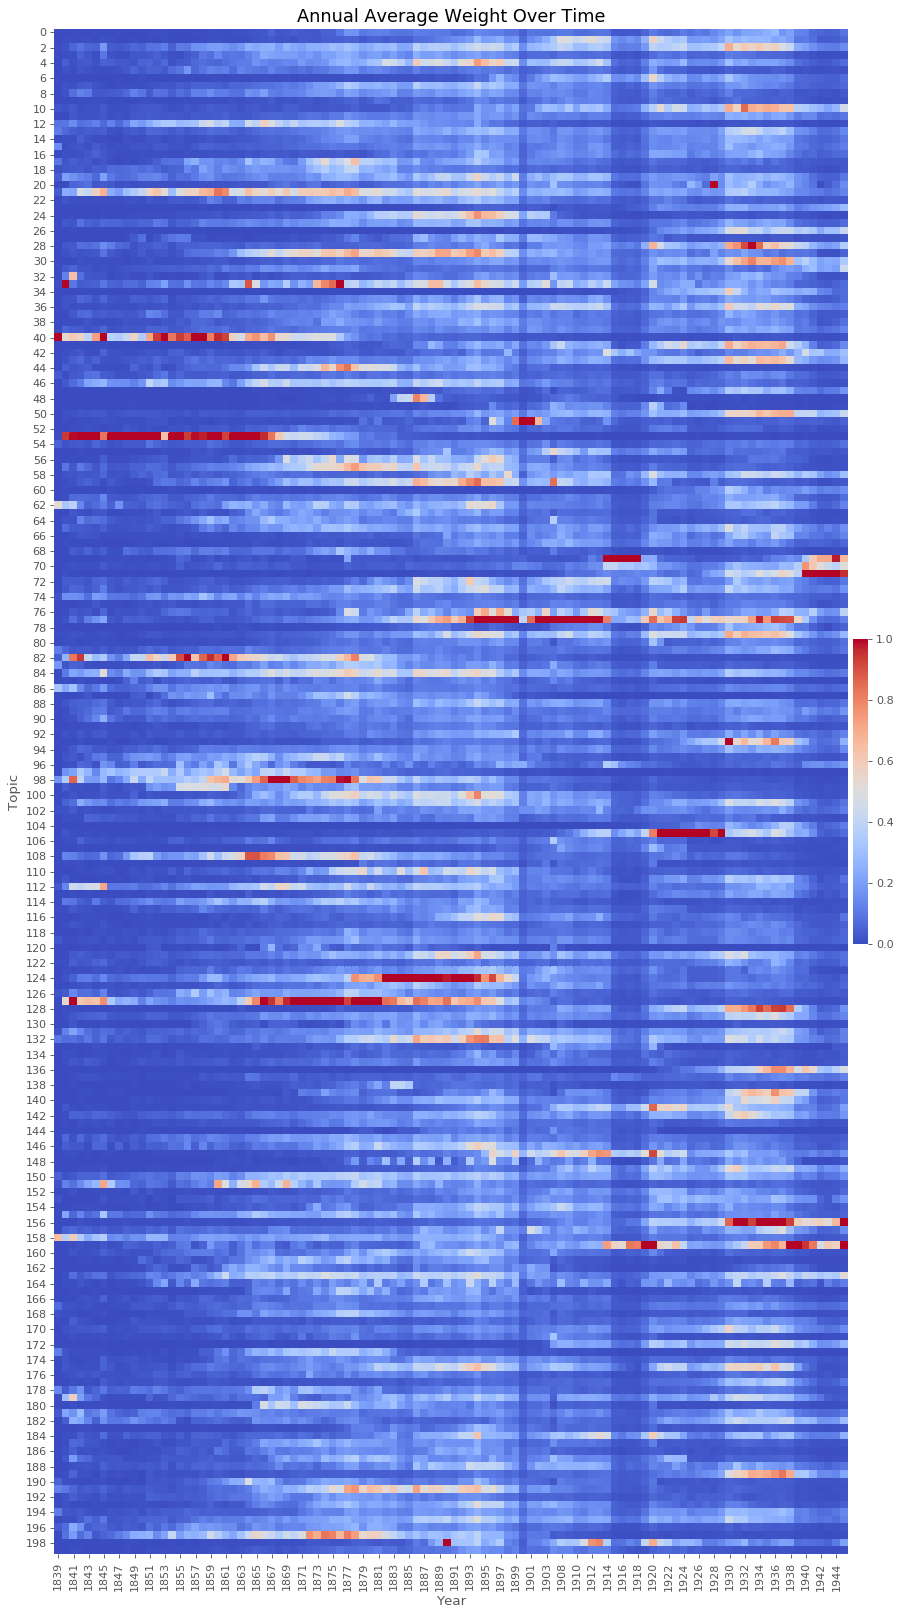

In [9]:
plot_heatmap(df_plt_scaled, path='../temp/plot_heatmap.png')

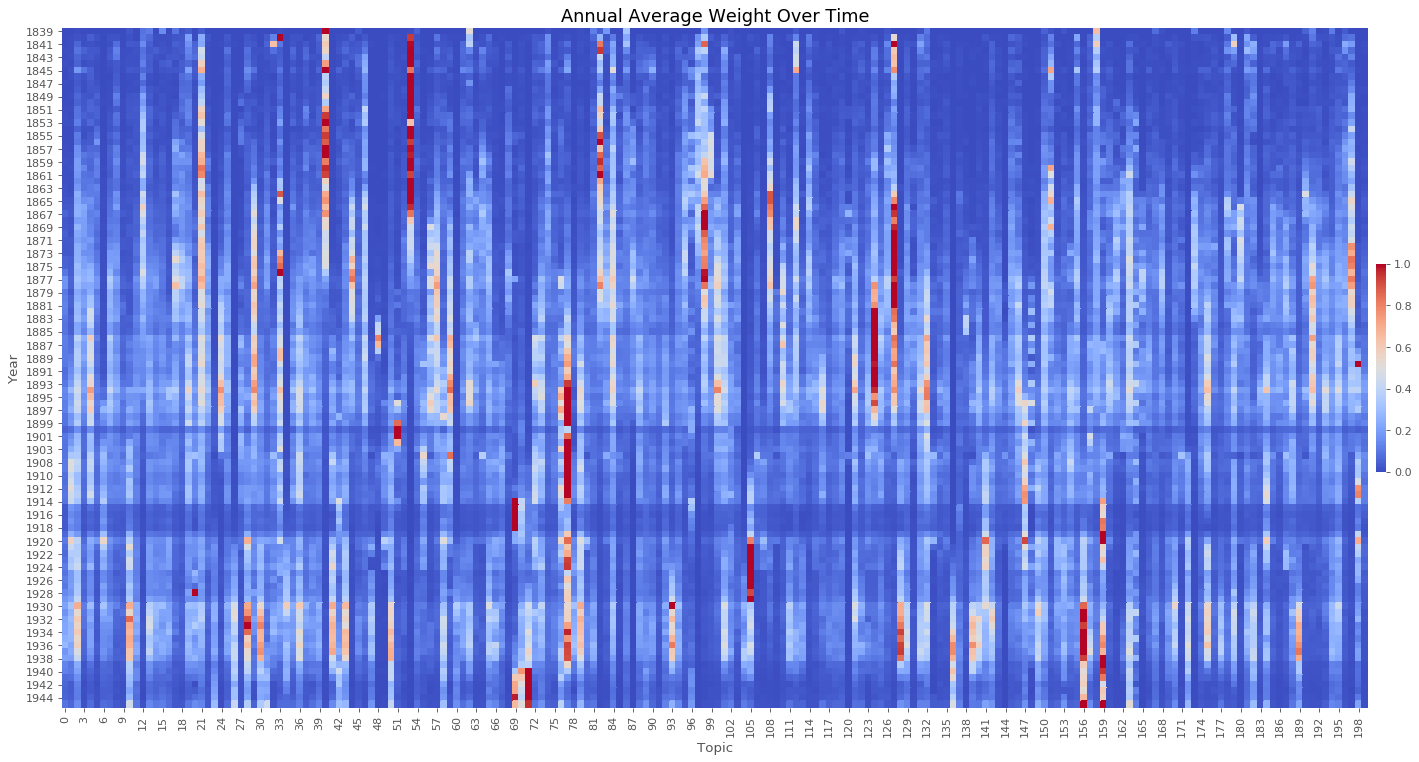

In [10]:
# this is for presentation slides.
plot_heatmap(df_plt_scaled, T=True, path='../temp/plot_heatmap_T.png')

## 3 Specific Topics

### 3.1 The Most Hot Topics

**From the [Annual Average Weight Over Time plot](#hot) we see the red spots, each red spot means this topic (y axis) is the hotest topic of this year (x axis), some topics are the hotest topic in continuely years. We filter out the hot topics and sort them by the count of being hot topic, which are the most hot topics.**

In [11]:
df_hot = pd.DataFrame(df_plt_scaled.astype(int).sum(axis=1), columns=['count'])
df_hot = df_hot[(df_hot != 0).any(axis=1)].sort_values(by='count', ascending=False)
topic_list = df_hot.index.tolist()
print('Most hot topics:')
df_hot.T

Most hot topics:


53   124  77   127  156  71   105  40   69   98   82   159  33   20   \
count   13   10    9    8    7    5    5    3    3    3    2    2    2    1   

       93   51   198  
count    1    1    1

In [12]:
df_topics_hot = filter_topics(df_topics, topic_list).set_index('topic')
df_topics_hot.loc[topic_list].head(len(topic_list))

weight  \
topic            
53     0.00348   
124    0.00914   
77     0.04036   
127    0.00831   
156    0.00977   
71     0.00452   
105    0.00663   
40     0.00566   
69     0.00744   
98     0.01129   
82     0.00688   
159    0.01358   
33     0.03857   
20     0.00452   
93     0.00339   
51     0.00626   
198    0.00768   

                                                                                                                      keywords  
topic                                                                                                                           
53     cases ditto sale casks boxes oil case white brandy foot ale tea sugar cwt assorted bags undersigned candles cubic iron   
124    london government british french foreign sir england news lord paris received france english general india march gre...  
77     association press received telegraph copyright london united july electric cable june sydney august april march aust...  
127    arrived tons port wellington sailed auckland schooner cargo yesterday melbourne left barque passengers lyttelton syd...  
156    government scheme department board work made system service local present public control minister new_zealand time d...  
71     air flying flight london aeroplane british aircraft machine miles bombs aeroplanes force enemy raid japanese machine...  
105    theatre picture pictures story programme to-night drama film comedy love star shown great girl play life feature nig...  
40     government provincial province council colony general superintendent public governor new_zealand colonial assembly h...  
69     german enemy germans front french british london fighting troops attack captured received line artillery russian sta...  
98     business public notice begs attention orders inform premises patronage general support stock undersigned advertiseme...  
82     sale apply land acres house particulars property terms town good sections situated lease section years farm road fre...  
159    german germany war france peace french berlin russia government allies received london paris italy germans britain b...  
33                                      tin ill oil lit mil day zealand ton tie hat aro fur aid tins ail end man hut til time   
20     auckland wellington left due london lyttelton october sydney december march january september february sailed novemb...  
93          good race mile furlongs ran won day straight run home half horse handicap field horses back front winner time win   
51     south africa boers british war general transvaal contingent boer london lord received african cape capetown men troo...  
198    strike union men miners labour work workers coal federation association conference labor dispute unions wages strike...

**Plot all average weight to check trend of each hotest topic.**

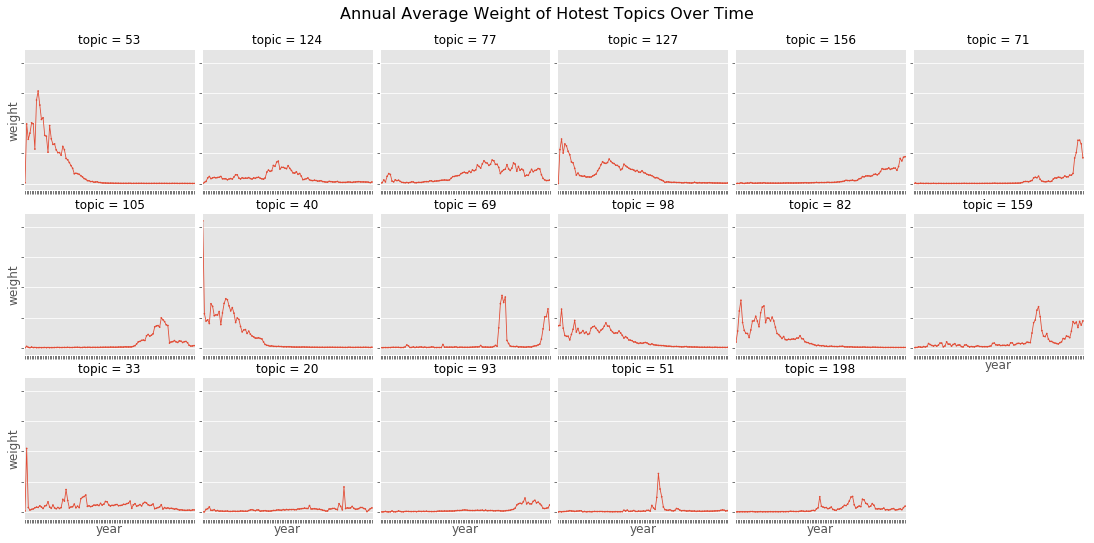

In [13]:
df_plt_avg = filter_topics(df_avgweight, topic_list)

plot_avg(df_plt_avg, col_wrap=6, col_order=topic_list, height=2.5, scale=0.3, adjust_top=0.9, 
         title='Annual Average Weight of Hotest Topics Over Time',
         path='../temp/plot_hotavg.png')

**Plot all hot topics with:**
* annual average weight
* dominant topic distribution
* dominant topic count

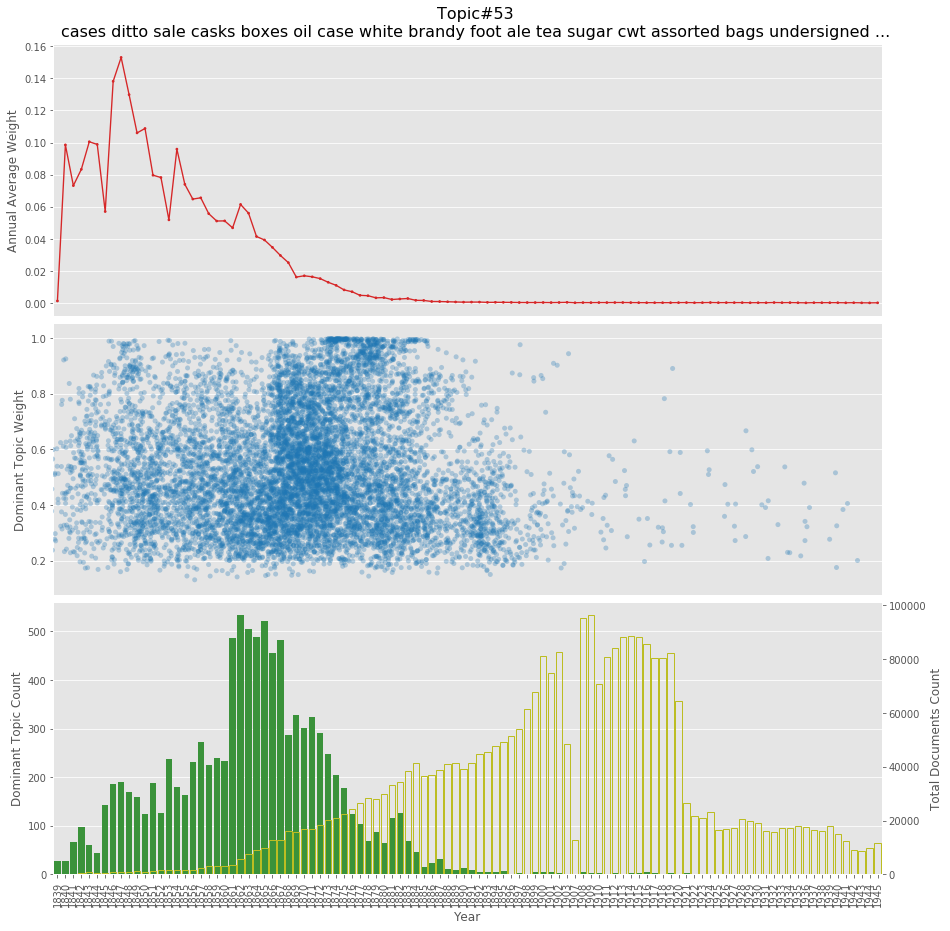

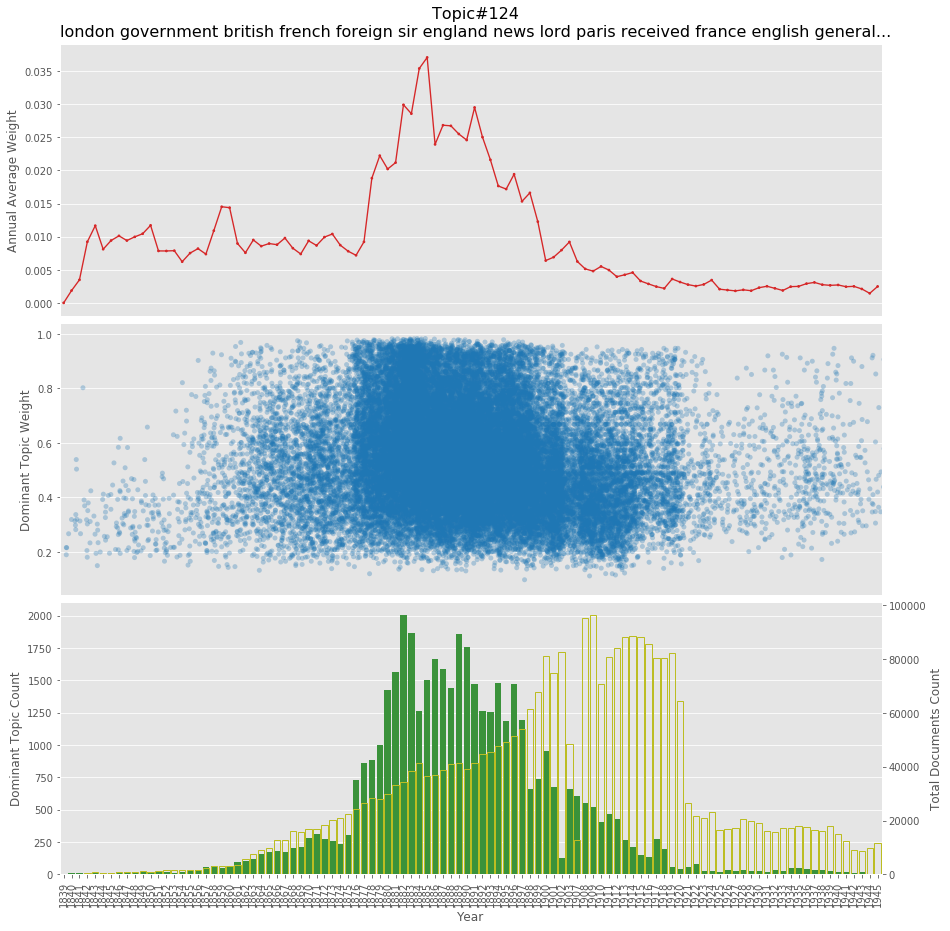

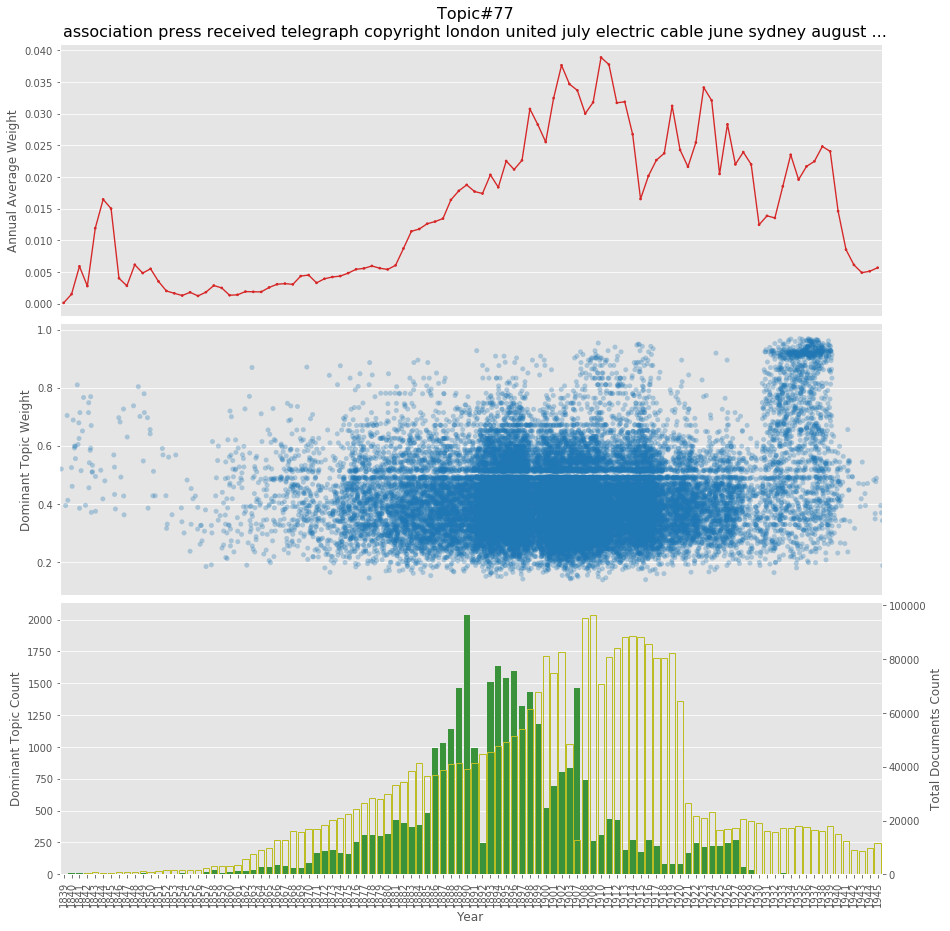

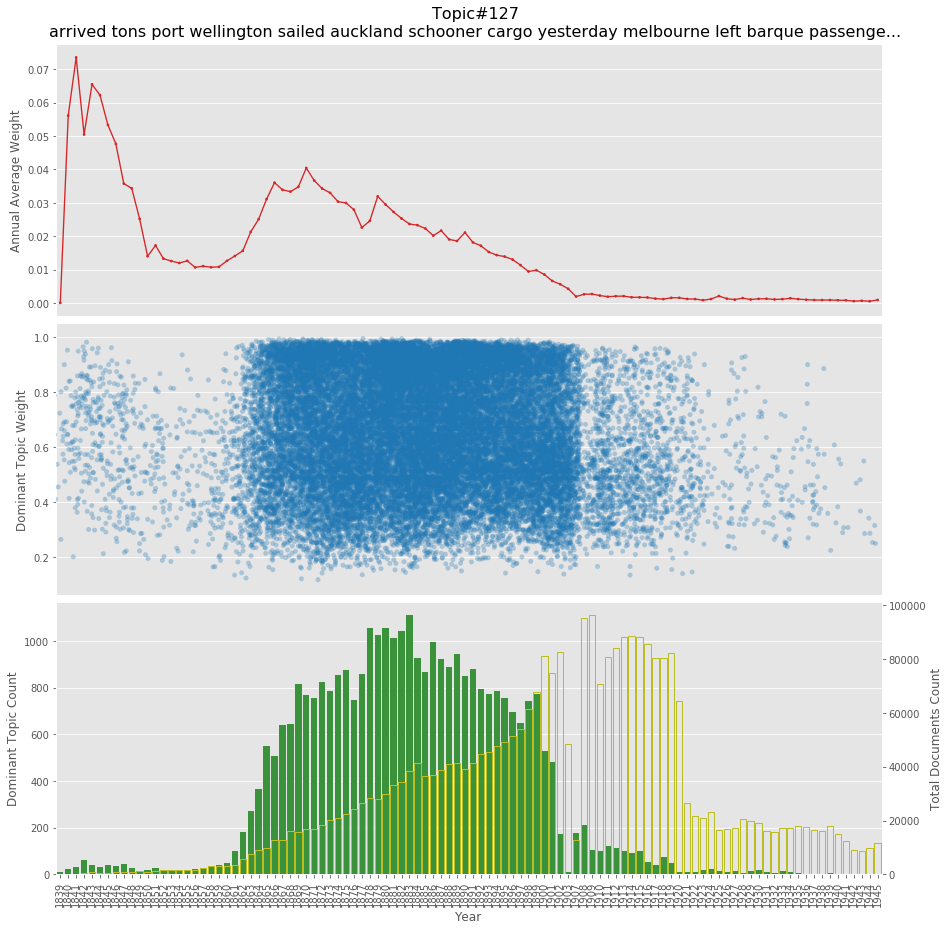

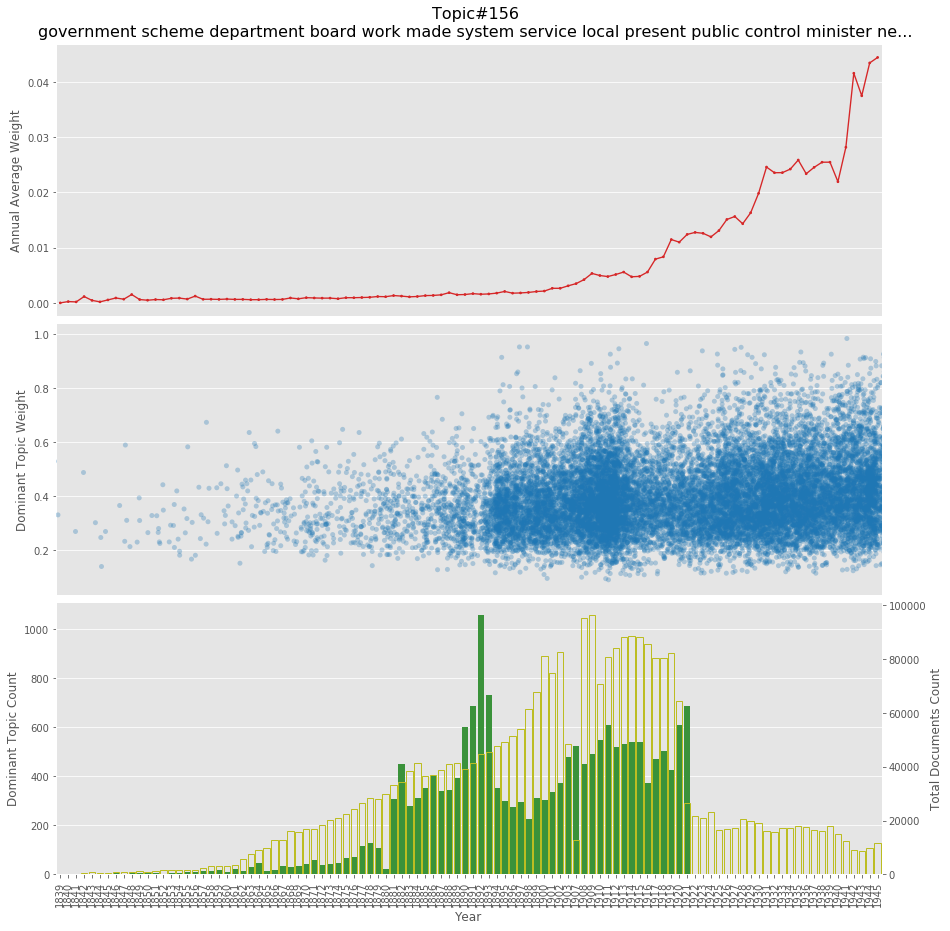

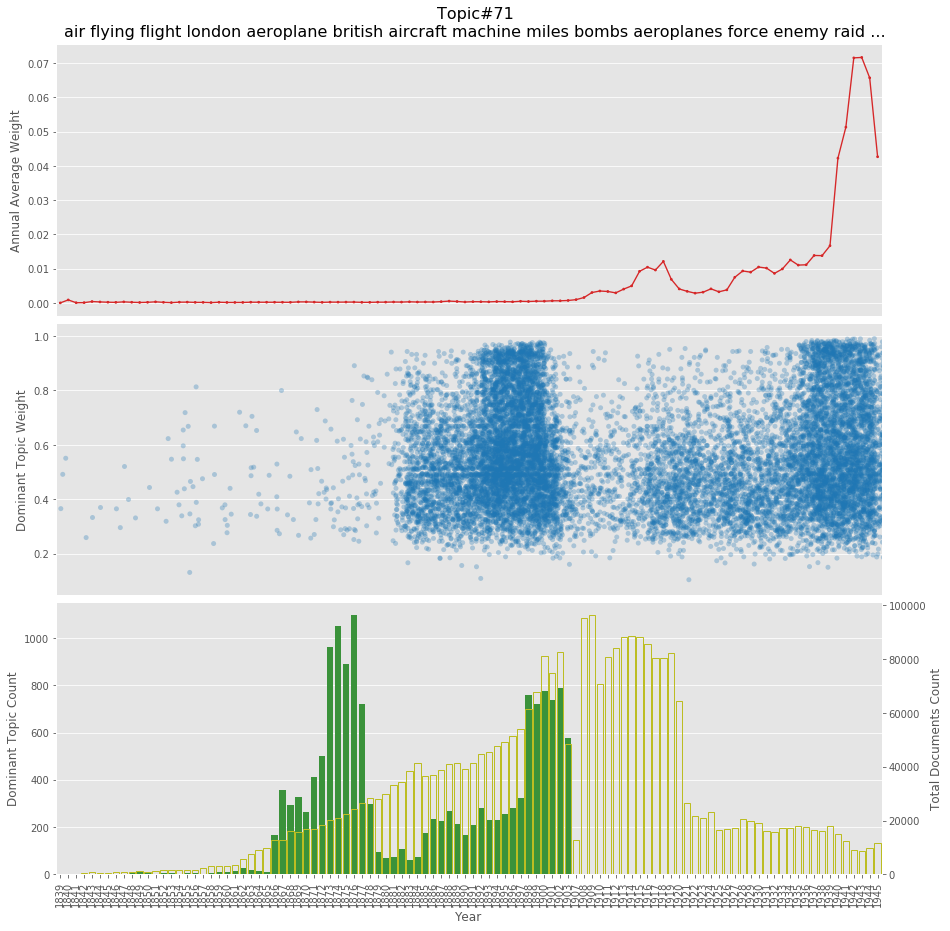

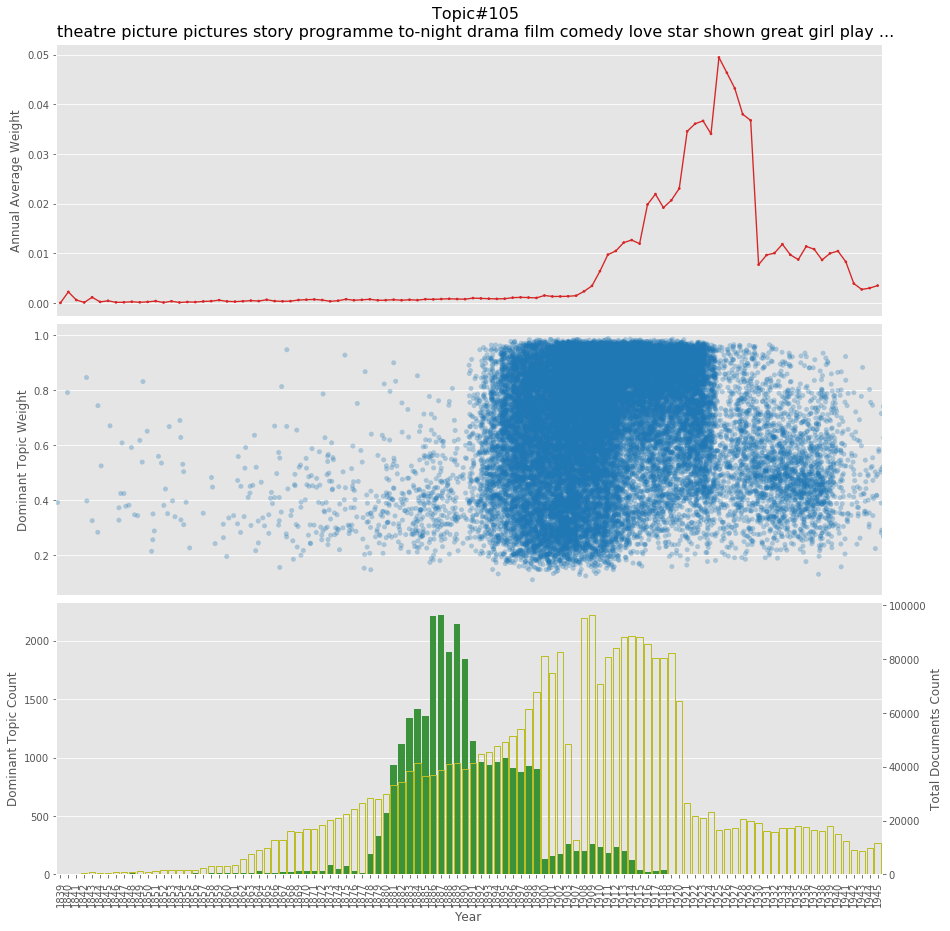

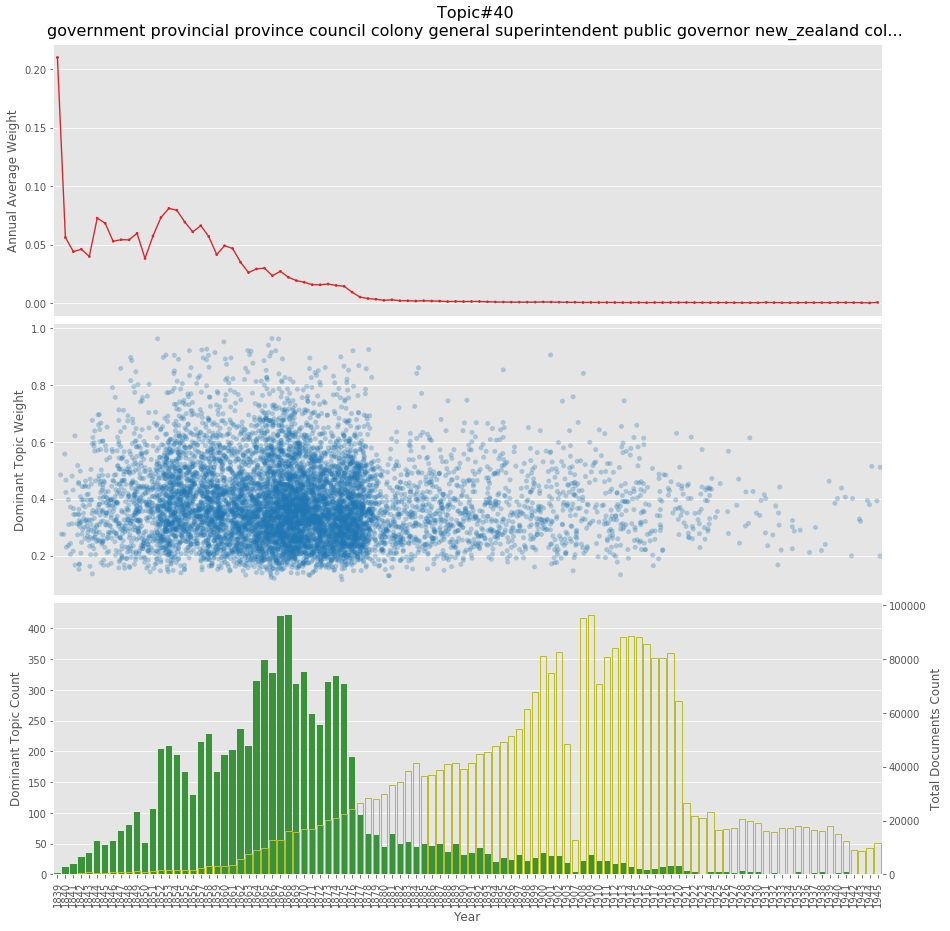

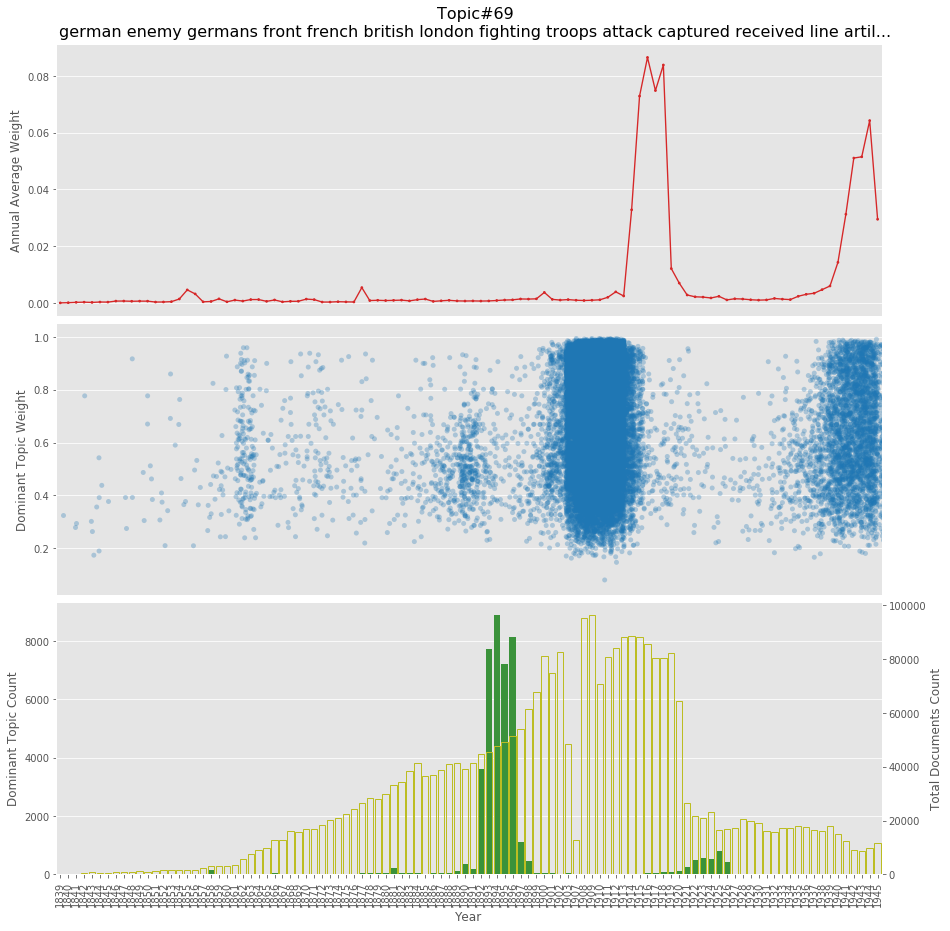

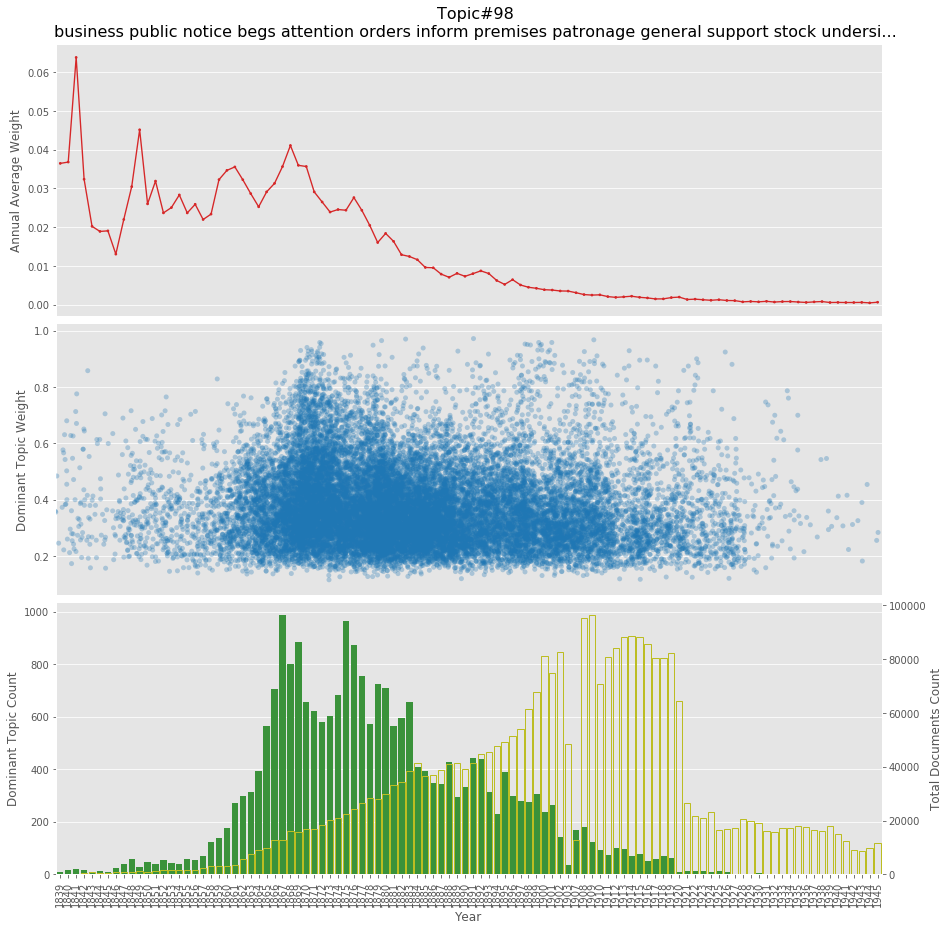

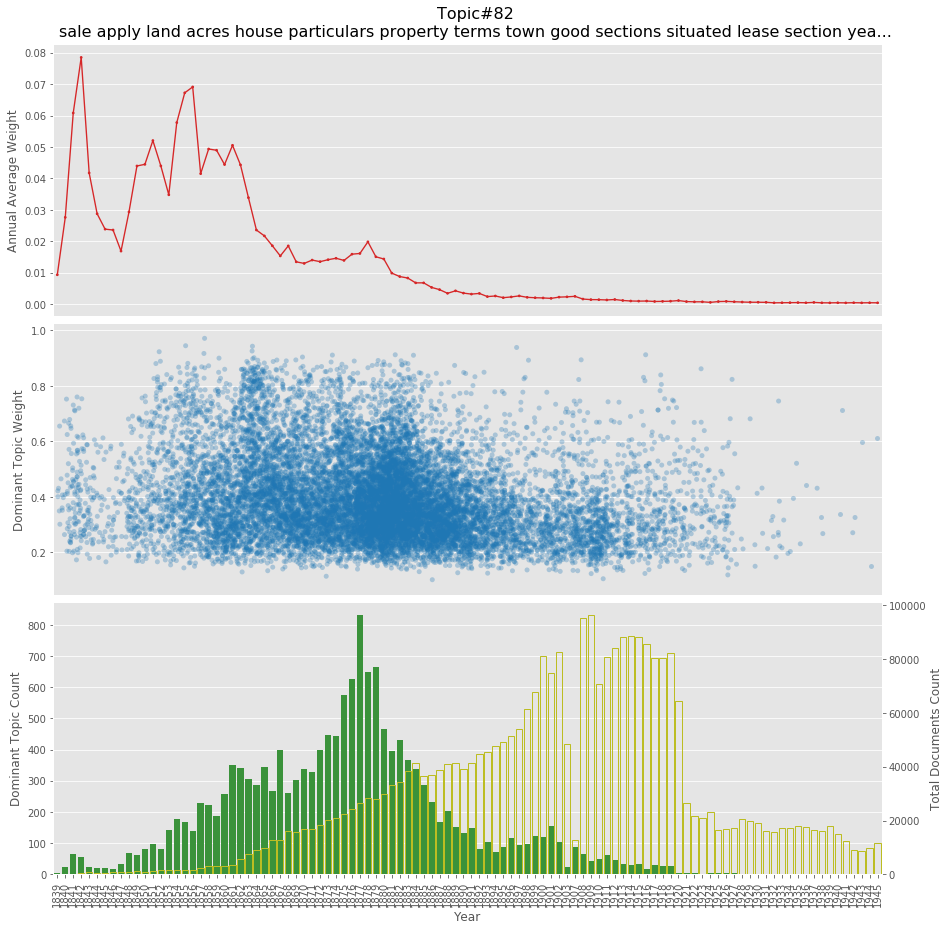

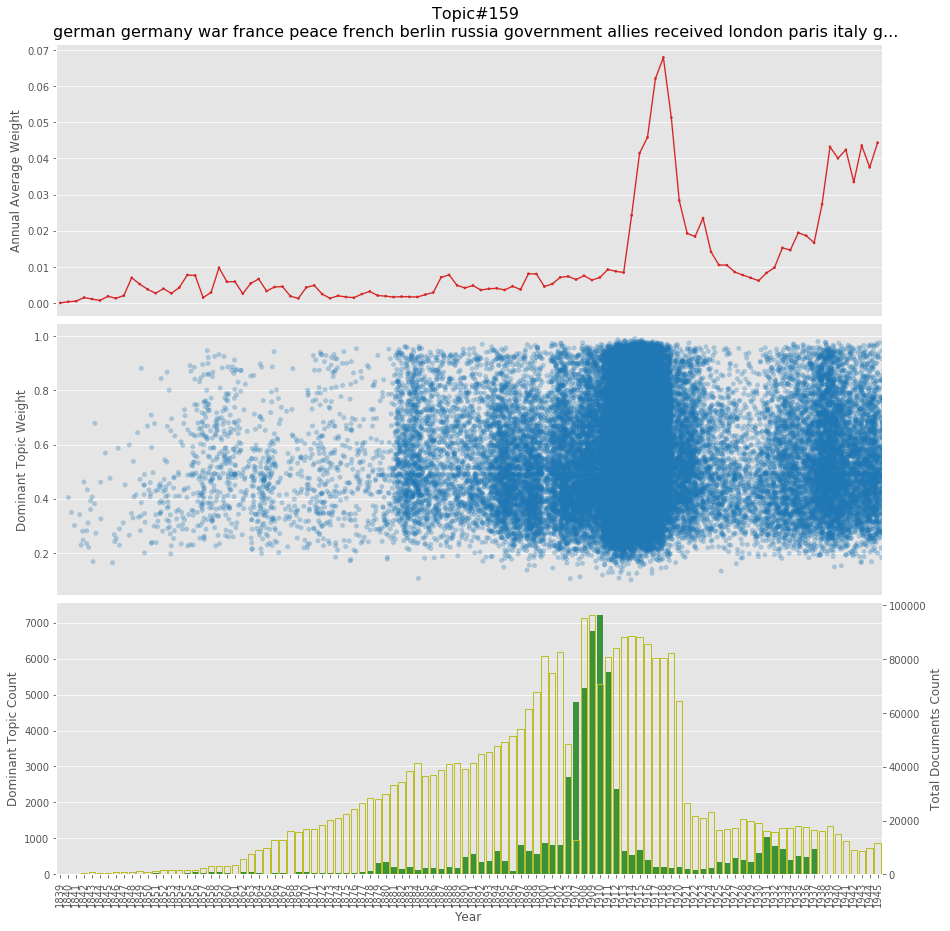

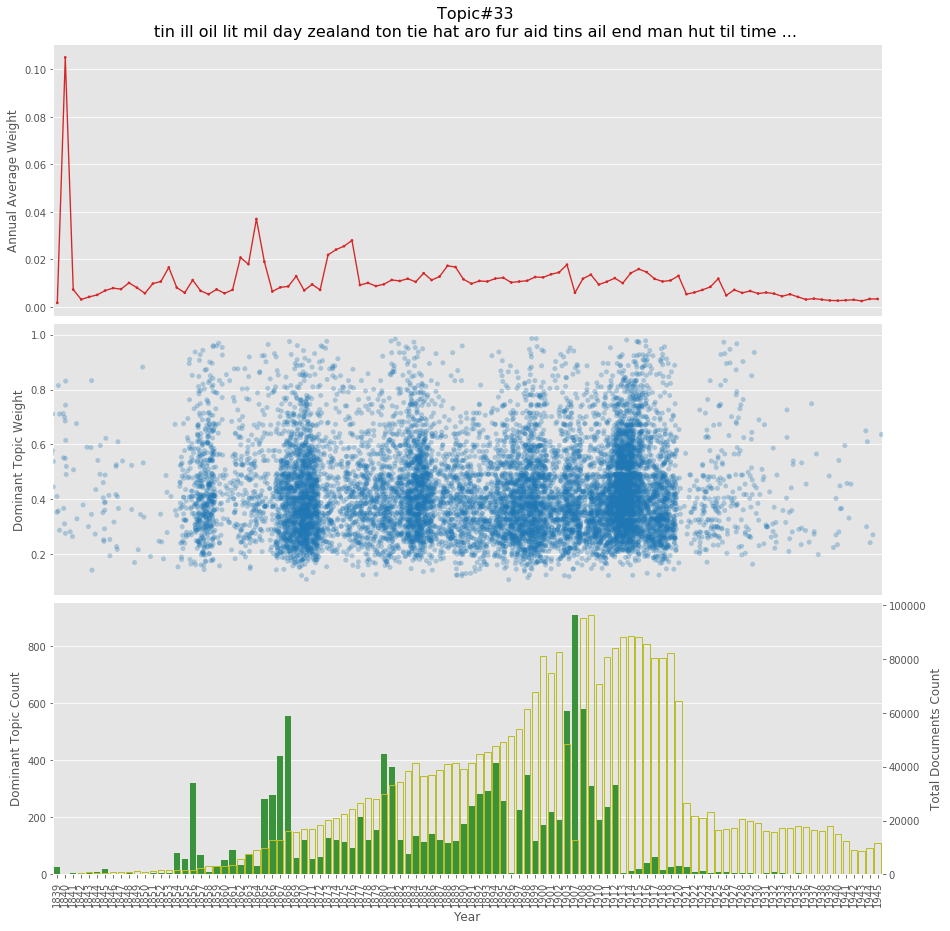

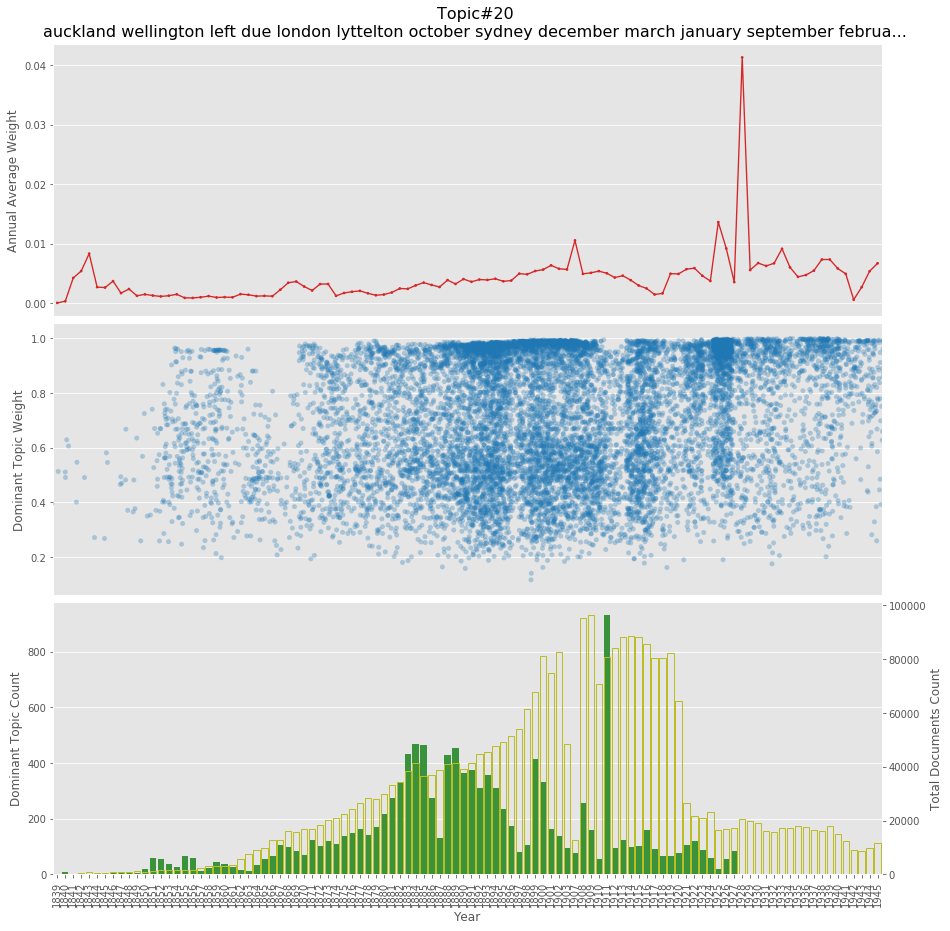

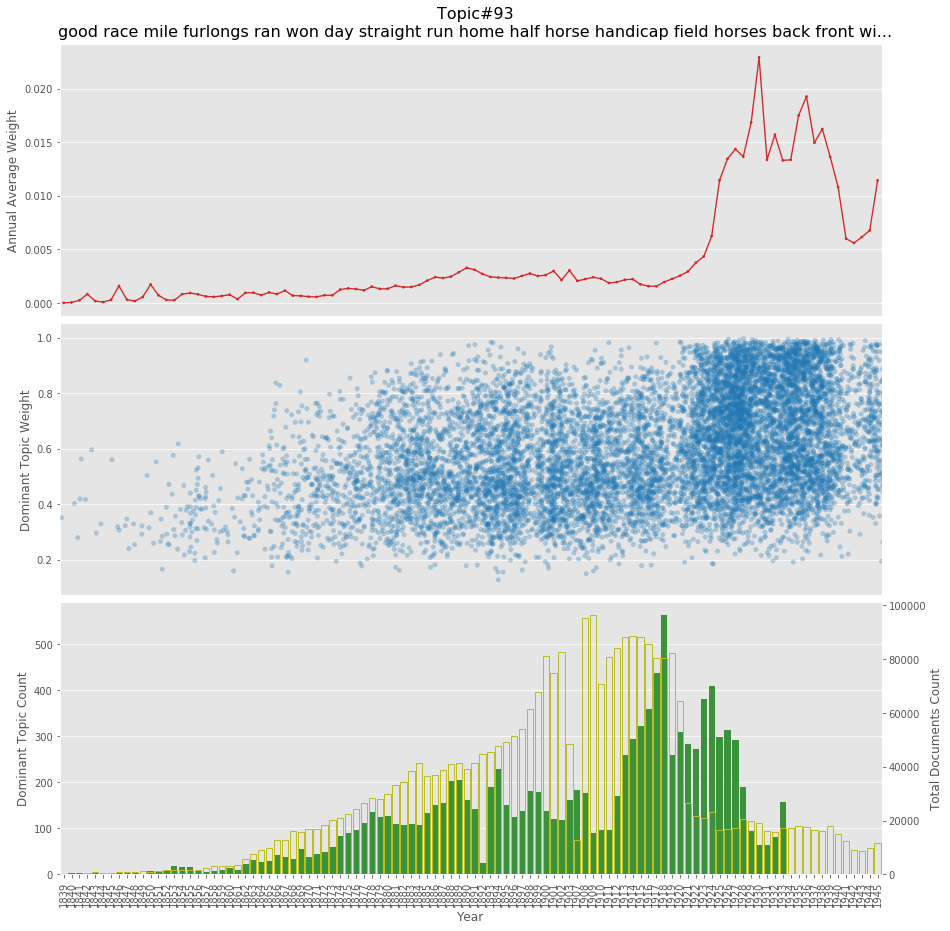

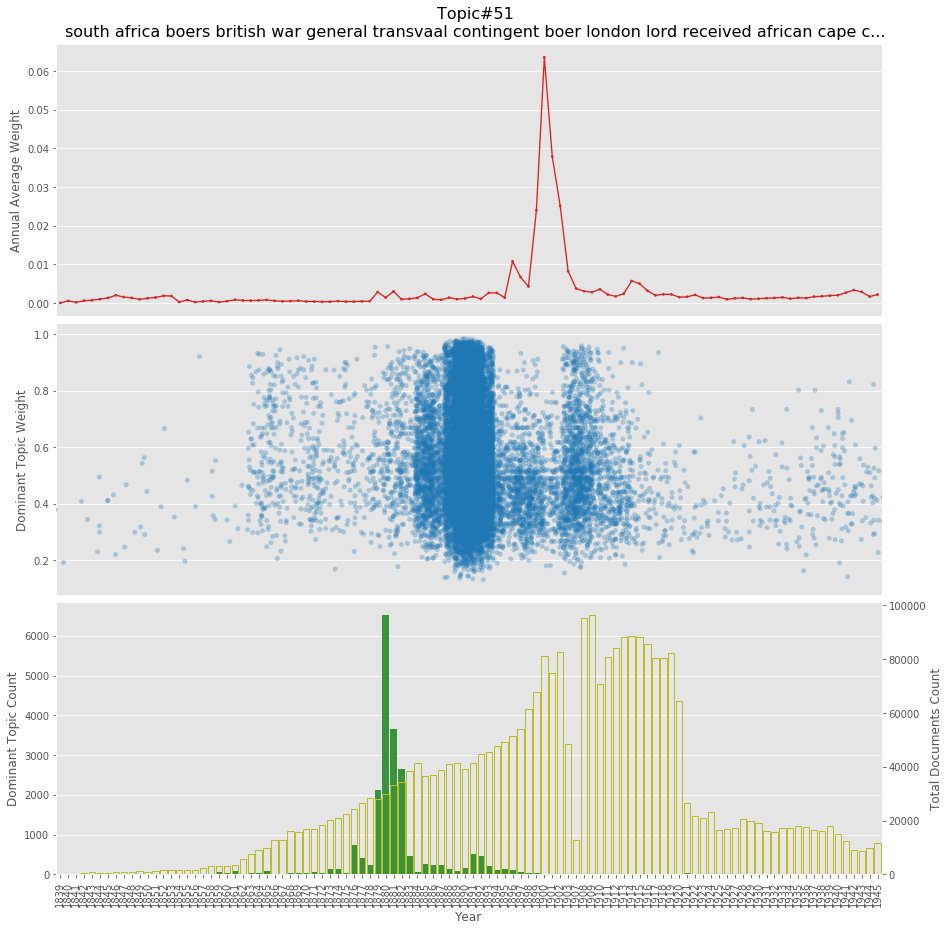

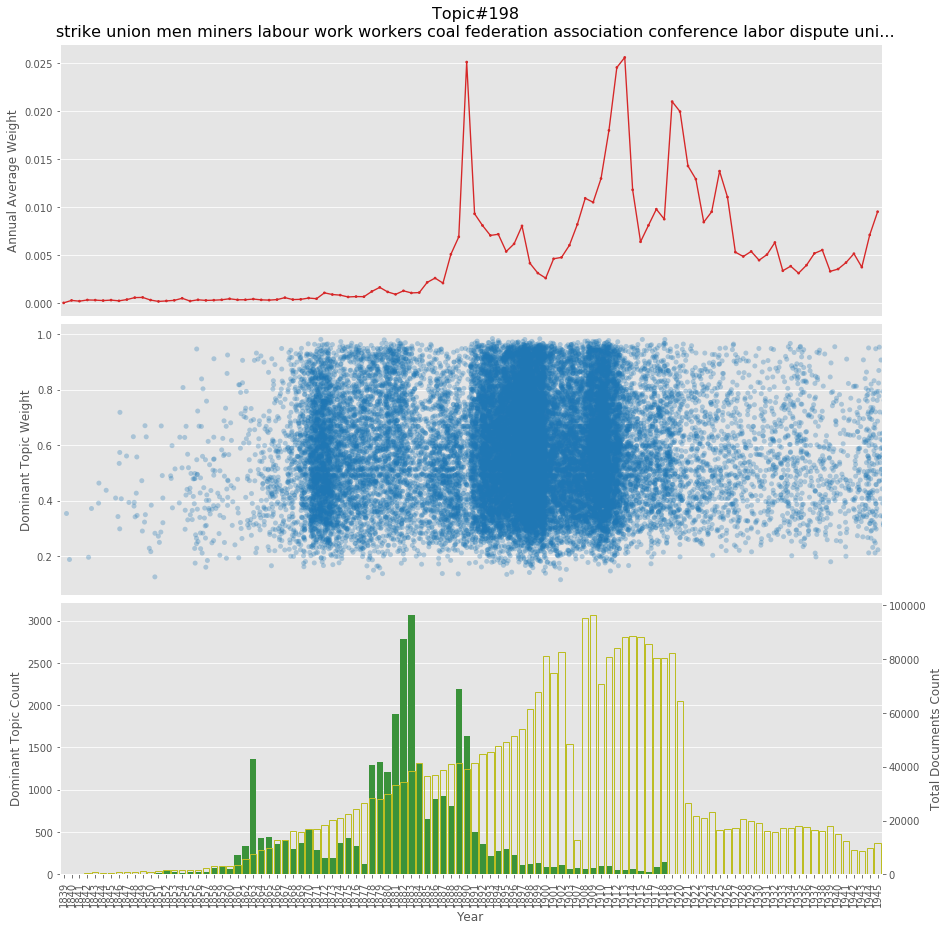

In [14]:
for topic in topic_list:
    plot_hot(topic, df_topics, df_domtopic, df_avgweight, path='../temp/plot_hot.png')

### 3.2 Several Interesting Topics

#### 3.2.1 War, Peace, Entertainment, Strike

**Here we compare several interesting topics after 1908.**

In [15]:
topic_list = [105, 69, 159, 198]

# topic of interest
df_topics_toi = filter_topics(df_topics, topic_list)
legend_labels = list(df_topics_toi.keywords.str.slice(0,70)+'...')
df_topics_toi.head()

topic   weight  \
69      69  0.00744   
105    105  0.00663   
159    159  0.01358   
198    198  0.00768   

                                                                                                                    keywords  
69   german enemy germans front french british london fighting troops attack captured received line artillery russian sta...  
105  theatre picture pictures story programme to-night drama film comedy love star shown great girl play life feature nig...  
159  german germany war france peace french berlin russia government allies received london paris italy germans britain b...  
198  strike union men miners labour work workers coal federation association conference labor dispute unions wages strike...

In [16]:
# generate dataframe to plot
df_plt_avg = filter_topics(df_avgweight, topic_list)
df_plt_avg = df_plt_avg.pivot(index='year', columns='topic', values='weight')
# convert to time series
df_plt_avg.index = pd.to_datetime(df_plt_avg.index)

# constrain years
df_plt_avg = df_plt_avg[df_plt_avg.index >= '1908-01-01']

df_plt_avg.sort_index()
df_plt_avg.sample(5)

topic            69        105       159       198
year                                              
1908-01-01  0.000859  0.002345  0.007548  0.010928
1939-01-01  0.005972  0.009987  0.043187  0.003314
1917-01-01  0.074810  0.021919  0.062072  0.009791
1934-01-01  0.001179  0.009699  0.014625  0.003851
1941-01-01  0.031247  0.008280  0.042371  0.004226

**Plot:**

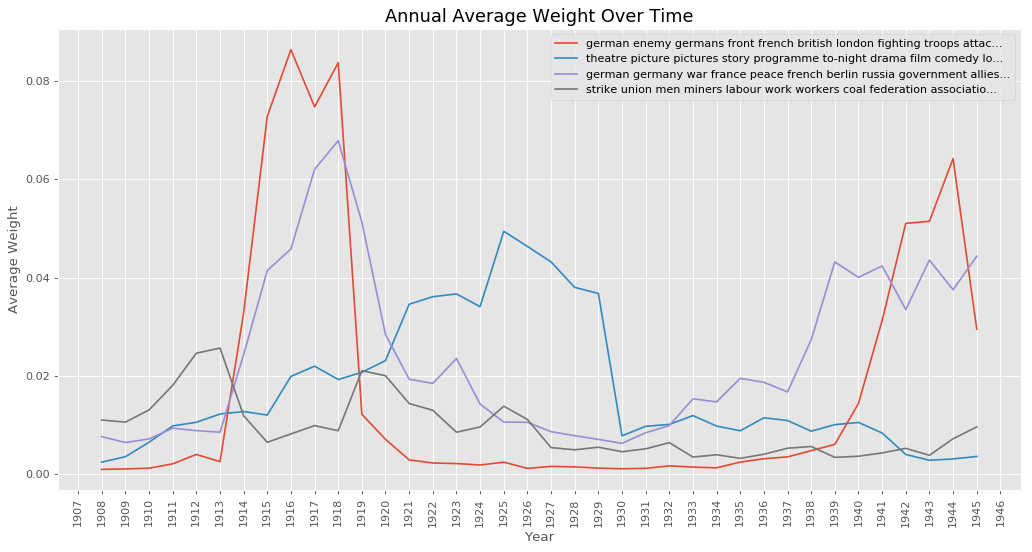

In [17]:
fig, ax = plt.subplots(figsize=(13, 7), dpi=dpi)

year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

for i, c in enumerate(df_plt_avg.columns):
    plt.plot_date(df_plt_avg.index, df_plt_avg[df_plt_avg.columns[i]], '-')
    
plt.xlabel('Year')
plt.ylabel('Average Weight')
plt.xticks(rotation='90')
plt.title("Annual Average Weight Over Time", fontdict=dict(size=16))
ax.legend(labels=legend_labels)
plt.tight_layout()
plt.show()

**Seems war, peace, entertainment and strike have kinds of connection, war and peace have the save trend, while strike and entertainment have the different trand with war and peace during war, a good point to continue study.**

---

In [18]:
gc.collect()

47233